# STDSR23 - Assignment-01

> Igor Abramov @IG_ragon B21-DS-01

# Quantile implementation

February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


In [1]:
from matplotlib import pyplot as plt
from scipy.stats import norm, beta
from typing import List
from sys import getsizeof
from math import floor, ceil
from bisect import bisect
from tqdm import tqdm
from time import time

import os
import numpy as np

## Abstract implementation

Can be used as a basic class for your implementation

In [2]:
class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]

This is just an example of the algorithm implementation.

In [3]:
class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm
    
    This algorithm implementation is 
    based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
    
    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic 
    # function call, because of the 
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

In [4]:
## YOUR IMPLEMENTATION HERE

class GKTuple:
    def __init__(self, v, g, delta):
        """
        :param v: value that corresponds to the element
        :param g: g = r_min(v_i) - r_min(v_(i-1)) it is the gap in ranks
            between current and previous element in summary
        :param delta: delta = r_max(v) - r_min(v) it is the range of ranks 
            for corresponding value v 
        """
        self.v = v  
        self.g = g
        self.delta = delta


class GKSummary:
    def __init__(self, eps):
            """
            Initialize algorighm with given eps and precompute 
            :param eps: epsilon-tolerance to error
            """
            self.n = 0 # seen numbers
            self.eps = eps # error tolerance parameter
            self.compress_intervals = floor(1 / (2 * self.eps)) # when to compress intervals
            self.tuples = [] # list of GKTuples
            self.vs = [] # for efficient insertion index search

    def insert(self, v):
        """
        Insert new value in GK summary
        :param v: value
        """
        ind = self.find_index(v)
        delta = floor(2 * self.eps * self.n) if ind != 0 and ind != len(self.tuples) else 0
        new_tuple = GKTuple(v, 1, delta)
        self.tuples.insert(ind, new_tuple)
        self.vs.insert(ind, v)
        self.n += 1

        if self.n % self.compress_intervals == 0:
            self.compress()

    def find_index(self, v):
        """
        Find such index that tuples[index - 1] <= v < tuples[index]
        :param v: element
        """
        index = bisect(self.vs, v)
        return index
    
    def compress(self):
        """
        Here we compress Summary
        """
        for i in range(len(self.tuples) - 2, 0, -1):
            while i < len(self.tuples) - 1 and self.delete(i):
                pass
    
    def delete(self, i):
        """
        If current index satisfies deletion conditions it will be compressed
        :param i: index to check
        """
        t1 = self.tuples[i]
        t2 = self.tuples[i + 1]
        threshold = floor(2 * self.eps * self.n)

        if t1.delta >= t2.delta and t1.g + t2.g + t2.delta < threshold:
            self.tuples.pop(i)
            self.vs.pop(i)
            t2.g += t1.g
    
    def quantile(self, phi) -> float:
        """
        Compute epsilon-approximation to phi-quantile
        Generally, we find such index i, such that
        for r = ceil(phi * n)
        r - r_i_min <= ceil(eps * n) and r_i_max - rank <= ceil(eps * n)

        :param phi: phi-quantile to compute
        """
        rank = ceil(phi * self.n)
        margin = ceil(self.eps * self.n)

        best_index = -1
        best_fit = np.inf
        rank_min = 0
        for i, t in enumerate(self.tuples):
            rank_min += t.g
            rank_max = rank_min + t.delta

            if rank - rank_min <= margin and rank_max - rank <= margin:
                curr_fit = abs(rank - (rank_min + rank_max) / 2)
                if curr_fit < best_fit:
                    best_fit = curr_fit
                    best_index = i
        if best_index == -1:
            raise LookupError("Failed to find requested quantile")

        return self.tuples[best_index].v
    

class GK01(BasicQuantileAlgorithm):
    def __init__(self, eps=1e-2):
        """
        Initializer of the class. 
        It initializes self.S with empty Summary
        """
        self.S = GKSummary(eps)
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.S.insert(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        for item in items:
            self.add_item(item)
    
    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        assert 0 <= q <= 1, f"Quantile q must be between 0 and 1 inclusive, got {q}"

        return self.S.quantile(q)
    
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute_quantile(q) for q in qs]

In [5]:
# A better function to calculate actual size of an object including its inner parts
# Found on stackoverflow https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj, verbose=False):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                if verbose:
                    print(obj)
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [6]:
# Demonstration of why it is a problem
print(getsizeof([1,2,3]), getsizeof([1.1,[2.2],3.3]), getsizeof(["Hello", 'World']))
print(getsize([1,2,3]), getsize([1.1,[2.2],3.3]), getsize(["Hello", 'World']))

80 80 72
164 216 180


In [7]:
getsize(GK01(), verbose=True)

{'S': <__main__.GKSummary object at 0x7f1124465550>}
{'n': 0, 'eps': 0.01, 'compress_intervals': 50, 'tuples': [], 'vs': []}
0
0.01
50
[]
[]


492

> YOUR REPORT ABOUT THE ALGORITHM

> Add comparison of the time and space consumption (with numpy algorithm). Plot them depending on the sample size or time if your algorithm is for time-series quantile calculation.

### My report about the GK01

After reading suggested literature review, I decided to implement *Felber15*, but after some investigation I saw that it used GK01 Summaries and also the quote from article 

> Afterwards, Felber et al. [43] came up with a randomized algorithm whose space complexity is $O(\frac{1}{\varepsilon}\log(\frac{1}{\varepsilon}))$ but also did not realize it. Besides, this algorithm is not actually useful but only suitable for theoretical study because its hidden coefficient of $O$ is too large.

discouraged me from implementing it. So I stick to GK01.

The study of Michael Greenwald and Sanjeev Khanna introduced new key data structure for storing and maintaining quantile information -- Summary.

But firstly we define what we need to accomplish. We want to perform $\varepsilon$-approximation of $\varphi$-quantile. It means the following: 
$\varphi$-quantile is the element at rank $r =  \lceil \varphi N \rceil$,  but for $\varepsilon$-approximation we are good if the true rank of retrieved element lies between $r - \varepsilon N$ and $r + \varepsilon N$. 

####Here goes the **Summary**
Summary data structure that contains tuples $t_i = (v_i, g_i, \Delta_i)$. Where $v_i$ is one of the elements seen so far, $g_i$ is the rank gap between minimal rank of $v_i$ and minimal rank of $v_{i-1}$, and $\Delta_i$ is the number of ranks that if covered by $v_i$. As $v_{i}$ comes in sorted order it is easy to see that $r_{min}(v_i)=\sum_{j\leq i}g_j$ and $r_{max}(v_i)=r_{min}(v_i) + \Delta_i$. 

#### Quantile($\varphi$)
So, to find $\varepsilon$-approximation of $\varphi$-quantile after $n$ observations we compute $r= \lceil \varphi n \rceil$, and find such $i$ that $r-r_{min}(v_i)\leq \varepsilon n$ and $r_{max}(v_i) - r\leq \varepsilon n$, and return $v_i$.

#### Insert($v$)
We find the smallest $i$, such that $v_{i-1}\leq v < v_i$ and insert tuple $(v, 1, \lfloor2\varepsilon n \rfloor)$ between $t_{i-1}$ and $t_i$. If $v$ is new minimum or maximum we insert $(v, 1, 0)$. 
After insertion, if $n \equiv 0 \mod \frac{1}{2\varepsilon}$ we perform Compress() operation.

#### Delete($v_i$)
To delete the tuple $(v_i, g_i, \Delta_i)$ from Summary we replace $(v_i, g_i, \Delta_i)$ and $(v_{i+1}, g_{i+1}, \Delta_{i+1})$ by new tuple $(v_{i+1}, g_i + g_{i+1}, \Delta_{i+1})$.

#### Compress()
In this function we go from second to max element to the minimum element (not inclusive) and if $\Delta_i \geq \Delta_{i+1}$ and $g_i + g_{i + 1}  + \Delta_{i+1} < \lfloor 2 \varepsilon n \rfloor$ we perform Delete(i)

### Pros and cons

Pros:
- It does not require N to be provided beforehand, unlike some of other algorithms (yes, MRL98, I'm about you)
- Better time for quantile retrieval for large N with comparison to basic algorithm
- More efficient memory utilization for large N with comparison to basic algorithm

Cons:
- Due to high memory constants, GK01 is inefficient for small N, both in terms of time and memory consumption.

In [56]:
def show_combined(data, x_labels, title=""):
    fig, ax = plt.subplots()
    colors = iter([(1,0,0, .5), (0,0,1, .5), (0,1,0, .5)])

    for label, heights in data.items():
        ax.bar(x_labels, heights, 1, label=label, color=next(colors))

    x_ticks = [t if i % 30 == 29 or i == 0 else '' for i, t in enumerate(x_labels)]
    ax.xaxis.set_ticks(x_ticks)
    ax.legend()
    ax.set_title(title) 
    ax.set_xlabel('Number of elements seen')        

    plt.gcf().set_size_inches(15, 10)
    plt.show()

### Memory usage examination GK01 vs Numpy

GK01 was created as an algorithm for quantile estimation that is more space-efficient than MLR98. The major improvement, besides better asymptotic memory usage, is that it can answer queries without fixed N, so the size of summary is mainly depends on the error margin.

First, I compare memory consumption of GK01 with eps=1e-3 and eps=2e-4 with the exact quantile algorithm NumpyQuantileAlgorithm

In [58]:
gk_quantile_alg_3 = GK01(eps=1e-3) 
gk_quantile_alg_4 = GK01(eps=2e-4)
np_quantile_alg = NumpyQuantileAlgorithm()

memory_usage = {
    "NumpyQuantileAlgorithm": [],
    "GK01 (eps=2e-4)": [],
    "GK01 (eps=1e-3)": []
}

cum_sum = []
for i, n in tqdm(list(enumerate(np.logspace(1, 3.5, 240)))):
    cum_sum.append(int(n))
    if i > 0:
        cum_sum[-1] += cum_sum[-2]

    random_values = list(norm.rvs(size=int(n))) # randomly sample from normal distribution, then add values to algs
    gk_quantile_alg_3.add_multiple_items(random_values)
    gk_quantile_alg_4.add_multiple_items(random_values)
    np_quantile_alg.add_multiple_items(random_values)
    
    
    memory_usage["GK01 (eps=1e-3)"].append(getsize(gk_quantile_alg_3))
    memory_usage["GK01 (eps=2e-4)"].append(getsize(gk_quantile_alg_4))
    memory_usage["NumpyQuantileAlgorithm"].append(getsize(np_quantile_alg))

100%|██████████| 240/240 [00:16<00:00, 14.20it/s]


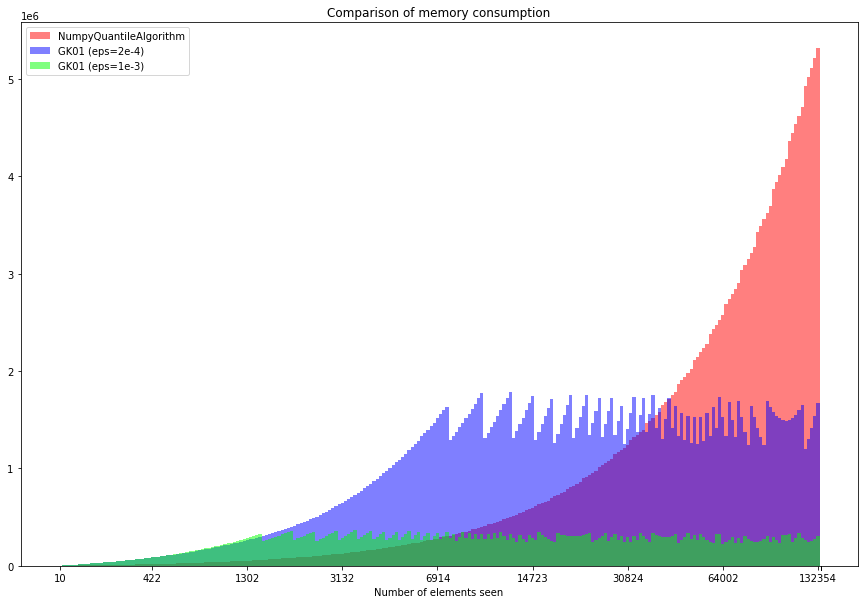

In [59]:
show_combined(memory_usage, list(map(str, cum_sum)), title="Comparison of memory consumption")

We can see the comparison of memory consumption of various algorithms above. GK01 (eps=1e-3) consumes roughly 7-8 times less memory than NumpyQuantileAlgorithm, and this gap will only increase with increase of N. Moreover it will increase drastically, as memory usage for GK01 flattens out after some threshold around 1/2ɛ elemets seen. 

In [61]:
median_4 = np.median(memory_usage["GK01 (eps=2e-4)"])
median_3 = np.median(memory_usage["GK01 (eps=1e-3)"])

gk4 = GK01(eps=2e-4)
gk4.add_multiple_items(memory_usage["GK01 (eps=2e-4)"])
median_4_estimated = gk4.compute_quantile(0.5)


gk3 = GK01(eps=1e-3)
gk3.add_multiple_items(memory_usage["GK01 (eps=1e-3)"])
median_3_estimated = gk3.compute_quantile(0.5)

print("Ratio of medians between two models", median_4 / median_3)
print("Ratio of estimated medians between two models", median_4_estimated / median_3_estimated)

Ratio of medians between two models 4.554173432235821
Ratio of estimated medians between two models 4.527675911070364


Reducing the error by a factor of 5 we expecting to get ~5 times more memory consumption for model with higher accuracy. Test revealed ~4.5x increase of memory usage, that is slightly better.

### **Time complexity** examination GK01 vs Numpy

In [62]:
gk_quantile_alg_3 = GK01(eps=1e-3) 
gk_quantile_alg_2 = GK01(eps=1e-2)
np_quantile_alg = NumpyQuantileAlgorithm()

time_adding = {
    "NumpyQuantileAlgorithm": [],
    "GK01 (eps=1e-3)": [],
    "GK01 (eps=1e-2)": []
}

time_computing = {
    "NumpyQuantileAlgorithm": [],
    "GK01 (eps=1e-3)": [],
    "GK01 (eps=1e-2)": []
}

cum_sum = []
qs = np.linspace(0, 1, 101)
for i, n in tqdm(list(enumerate(np.logspace(1, 4.6, 240).astype(int)))):
    cum_sum.append(n)
    if i > 0:
        cum_sum[-1] += cum_sum[-2]

    random_values = list(norm.rvs(size=n))

    # time the time it needs to add next n elements
    t1 = time()
    gk_quantile_alg_3.add_multiple_items(random_values)
    t2 = time()
    time_adding["GK01 (eps=1e-3)"].append(1000 * (t2 - t1) / n)

    t1 = time()
    gk_quantile_alg_2.add_multiple_items(random_values)
    t2 = time()
    time_adding["GK01 (eps=1e-2)"].append(1000 * (t2 - t1) / n)

    t1 = time()
    np_quantile_alg.add_multiple_items(random_values)
    t2 = time()
    time_adding["NumpyQuantileAlgorithm"].append(1000 * (t2 - t1) / n)
    
    t1 = time()
    gk_quantile_alg_3.multi_compute(qs)
    t2 = time()
    time_computing["GK01 (eps=1e-3)"].append(1000 * (t2 - t1))

    t1 = time()
    gk_quantile_alg_2.multi_compute(qs)
    t2 = time()
    time_computing["GK01 (eps=1e-2)"].append(1000 * (t2 - t1))

    t1 = time()
    np_quantile_alg.multi_compute(qs)
    t2 = time()
    time_computing["NumpyQuantileAlgorithm"].append(1000 * (t2 - t1))

100%|██████████| 240/240 [00:31<00:00,  7.66it/s]


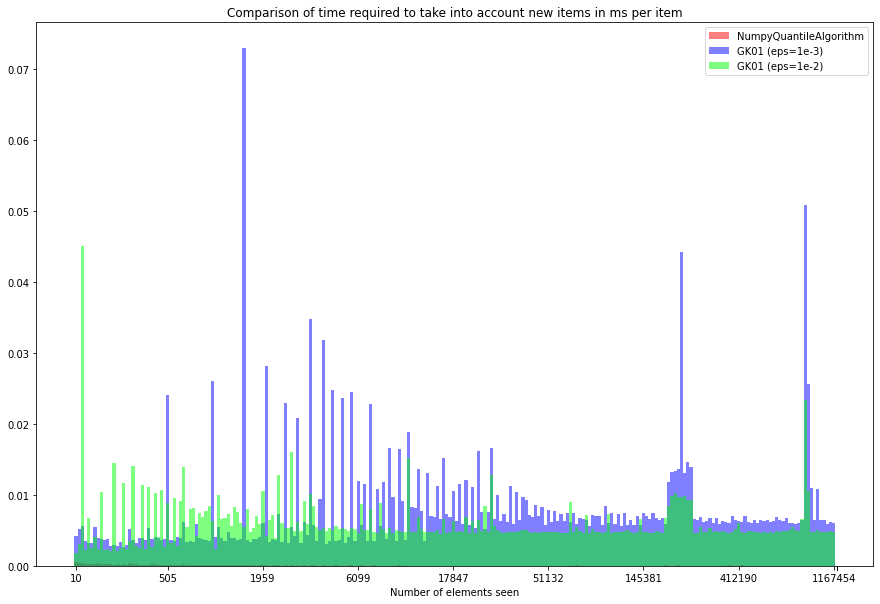

In [63]:
show_combined(time_adding, list(map(str, cum_sum)), title="Comparison of time required to take into account new items in ms per item")

Here we can see, that it usually takes less than 0.01 ms to add one item, and after ~1/2ɛ elements such time flattens.

We barely see Numpy part here, because in its implementation we use python list concatenation, which is a lot faster than inserting elements into GK Summary.

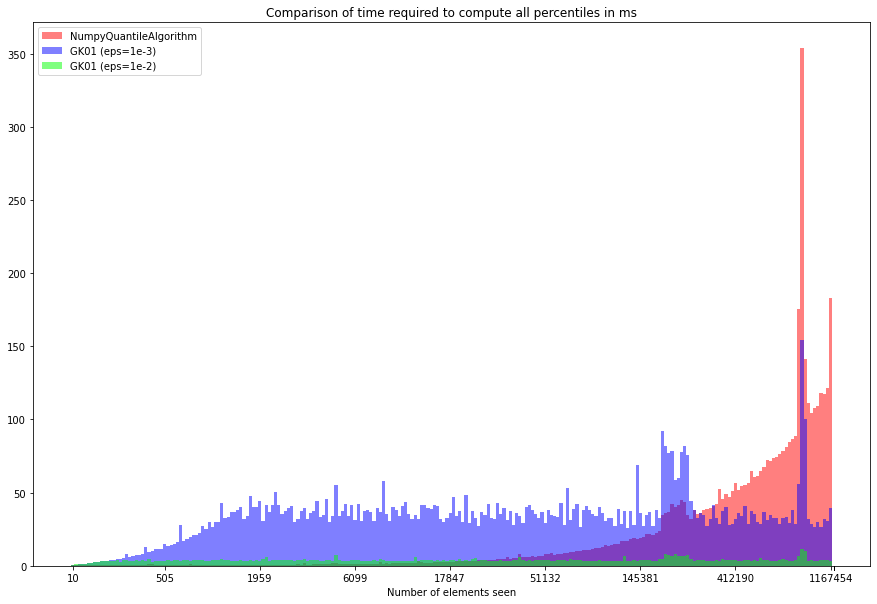

In [64]:
show_combined(time_computing, list(map(str, cum_sum)), title="Comparison of time required to compute all percentiles in ms")

And on this graph we see that both GK algorithms outperformed Numpy in the long run. Again, after ~1/2ɛ elements the time graph flattens out, because Summary reached its peak capacity.

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

In [ ]:
qs = np.linspace(0, 1, 1001)
inverse_cdf = [norm.ppf(q) for q in qs] # ppf is an inverse cdf

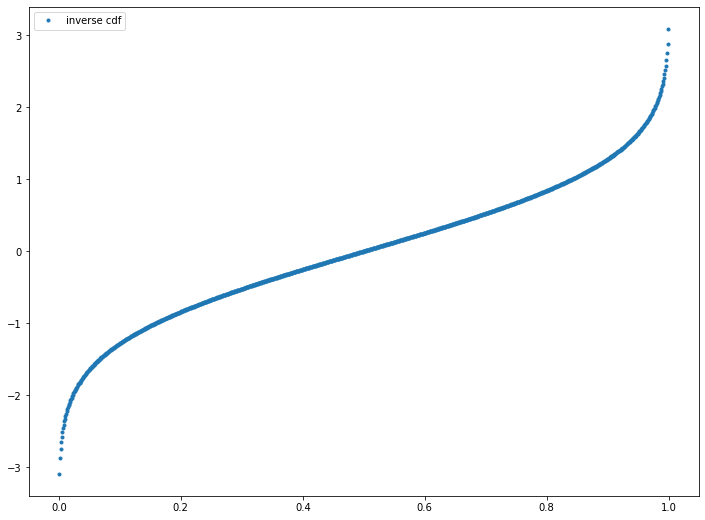

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(qs, inverse_cdf, '.', label='inverse cdf')
plt.legend()
plt.show()

### Make cool gif of convergence to inverse CDF 

In [ ]:
path_to_convergance_to_inv_cdf = "/content/convergance_to_inv_cdf"
if not os.path.exists(path_to_convergance_to_inv_cdf):
    os.makedirs(path_to_convergance_to_inv_cdf)

In [ ]:
gk_quantile_alg = GK01(eps=1e-3) # we set error to 0.001 as we are dealing with quantiles with step 0.001

for i, n in tqdm(list(enumerate(np.logspace(1, 2.5, 240)))):
    
    gk_quantile_alg.add_multiple_items(norm.rvs(size=int(n)))  # randomly sample n items from standard normal distribution
    gk_quantiles = gk_quantile_alg.multi_compute(qs) # actually useful function

    # making gif stuff
    plt.figure(figsize=(15, 10))
    plt.plot(qs, inverse_cdf, '.', label='inverse cdf')
    plt.plot(qs, gk_quantiles, '.', label=f'GK01 estimated quantiles n={gk_quantile_alg.S.n}')
    plt.legend()
    plt.savefig(f'{path_to_convergance_to_inv_cdf}/{i:0>6}.png')
    plt.close()

100%|██████████| 240/240 [02:25<00:00,  1.65it/s]


In [ ]:
import imageio
import os

with imageio.get_writer('conv_to_inv_cdf.gif', mode='I') as writer:
    for filename in tqdm(sorted(os.listdir(path_to_convergance_to_inv_cdf))):
        filepath = os.path.join(path_to_convergance_to_inv_cdf, filename)
        image = imageio.imread(filepath)
        writer.append_data(image)

100%|██████████| 240/240 [00:37<00:00,  6.36it/s]


In [ ]:
import shutil
shutil.rmtree(path_to_convergance_to_inv_cdf)

#### Cool gif of convergence to inverse CDF
Here we converge to inverse CDF of standart normal distribution

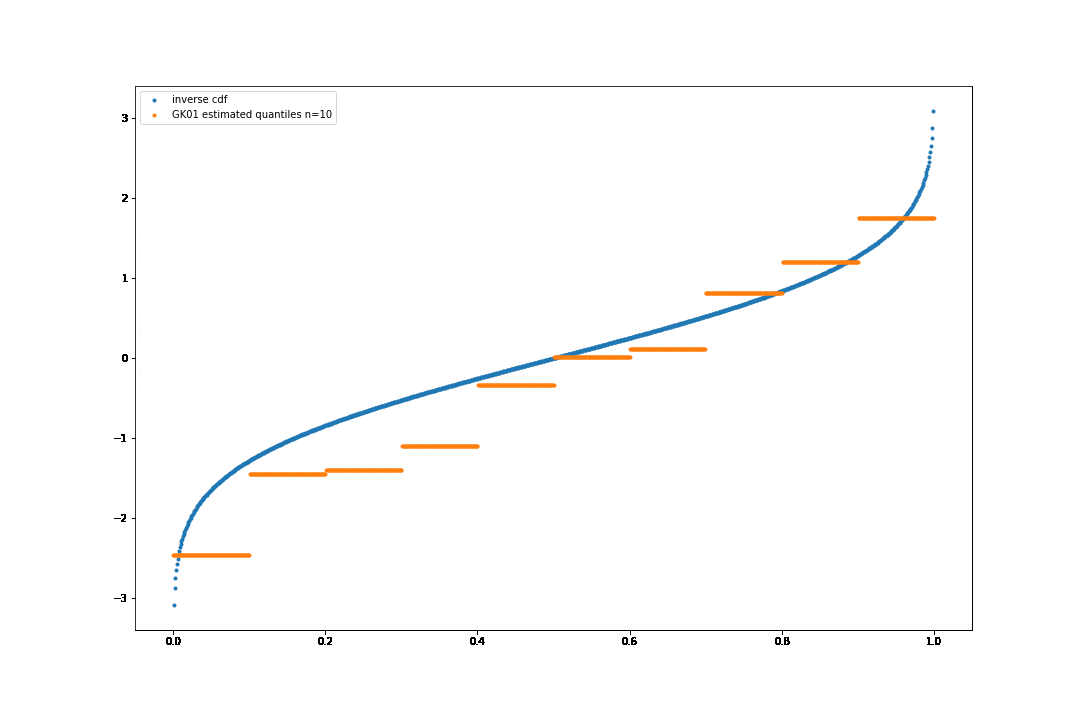

### Make the second cool gif of convergence to inverse CDF of Beta-distribution

For the second continious distribution I will use Beta-distribution with α = 0.9, β = 3

Which looks like this:

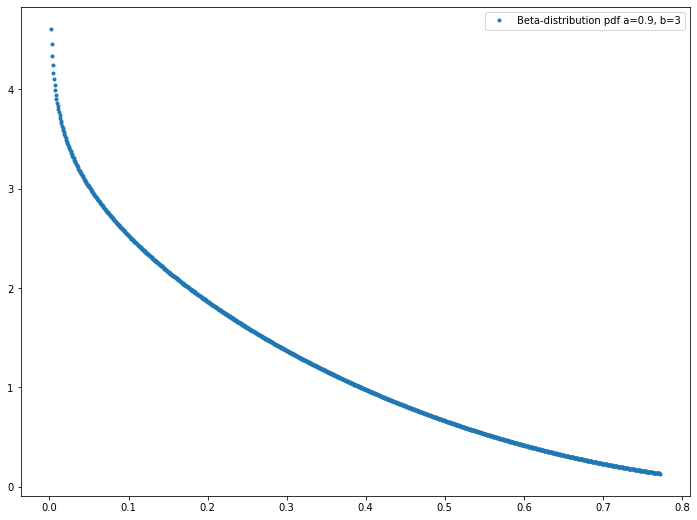

In [ ]:
plt.figure(figsize=(12, 9))
a = 0.9
b = 3
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 1000)
plt.plot(x, beta.pdf(x, a, b), '.', label=f'Beta-distribution pdf a={a}, b={b}')
plt.legend()
plt.show()

In [ ]:
qs = np.linspace(0.001, 0.999, 999)
inverse_cdf = [beta.ppf(q, a, b) for q in qs] # ppf is an inverse cdf in some sense

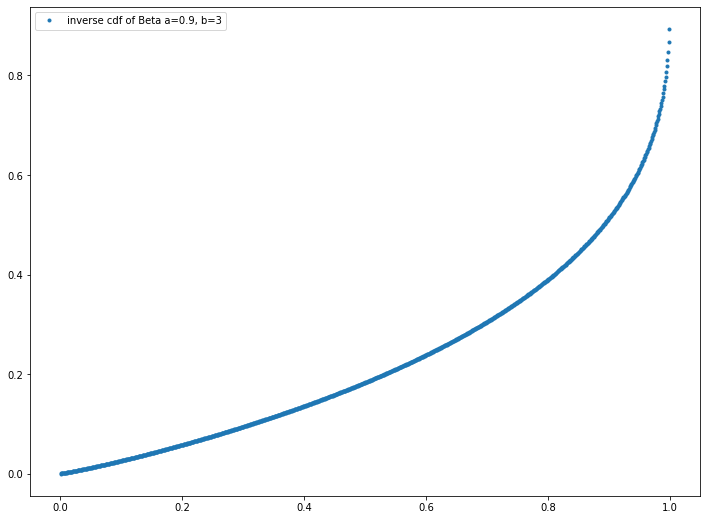

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(qs, inverse_cdf, '.', label=f'inverse cdf of Beta a={a}, b={b}')
plt.legend()
plt.show()

In [ ]:
path_to_convergance_to_inv_cdf = "/content/convergance_to_inv_cdf_b"
if not os.path.exists(path_to_convergance_to_inv_cdf):
    os.makedirs(path_to_convergance_to_inv_cdf)

In [ ]:
gk_quantile_alg = GK01(eps=1e-3) # we set error to 0.001 as we are dealing with quantiles with step 0.001

for i, n in tqdm(list(enumerate(np.logspace(1, 2.5, 240)))):
    gk_quantile_alg.add_multiple_items(beta.rvs(a, b, size=int(n))) # randomly sample from beta distribution next n samples 

    gk_quantiles = gk_quantile_alg.multi_compute(qs) # actually useful function

    # making gif stuff
    plt.figure(figsize=(15, 10))
    plt.plot(qs, inverse_cdf, '.', label='inverse cdf')
    plt.plot(qs, gk_quantiles, '.', label=f'GK01 estimated quantiles n={gk_quantile_alg.S.n}')
    plt.legend()
    plt.savefig(f'{path_to_convergance_to_inv_cdf}/{i:0>6}.png')
    plt.close() # so that we abandon 240 plots from our viewer

100%|██████████| 240/240 [02:22<00:00,  1.69it/s]


In [ ]:
import imageio
import os

with imageio.get_writer('conv_to_inv_cdf_b.gif', mode='I') as writer:
    for filename in tqdm(sorted(os.listdir(path_to_convergance_to_inv_cdf))):
        filepath = os.path.join(path_to_convergance_to_inv_cdf, filename)
        image = imageio.imread(filepath)
        writer.append_data(image)

100%|██████████| 240/240 [00:36<00:00,  6.54it/s]


In [ ]:
import shutil
shutil.rmtree(path_to_convergance_to_inv_cdf)

#### Another cool gif of convergence to inverse CDF
Now we converge to inverse cdf of Beta-distribution!!!

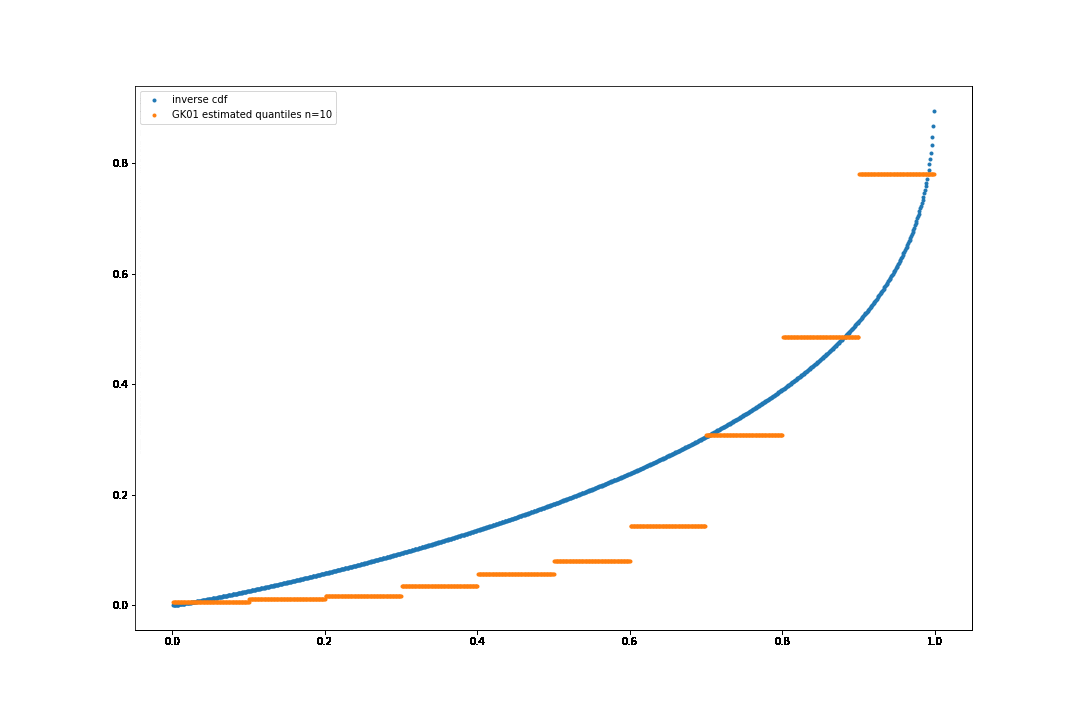

## Perform an experiment that shows the main purpose of the algorithm. 

For example, some algorithms are created especially for time series data, so you should show that your algorithm is working in time series environment properly.

The correctness of working with stream models is provided above, as in my setup I dynamically add more elements to the Algorithm and compute quantiles (i.e I do not recreate GK01 object, but add to it more and more data). As we can observe, for both distributions, my implementation converges to inverse CDF of corresponding distribution.

Also, when comparing memory and time consumption, I followed the same setup, so previous experements can be considered as "showing the main purpose", as in both cases my GK01 outperformed Numpy.

### Performance on random input of various sizes

In [ ]:
def test_accuracy(N, nq=100):
    N = int(N)
    gk = GK01(eps=1e-3)
    data = np.random.randn(N)

    gk.add_multiple_items(data)

    data = np.sort(data)

    qs = [i/(nq + 1) for i in range(1, nq + 1)]

    true_rank = []
    recieved_rank = []
    for q in qs:
        gk_v = gk.compute_quantile(q)
        recieved_rank.append(bisect(data, gk_v))
        true_rank.append(ceil(N * q))
    
    true_rank = np.array(true_rank)
    recieved_rank = np.array(recieved_rank)
    
    return (recieved_rank - true_rank) / N

In [ ]:
ns = [1e4, 1e5, 1e6, 1e7]


error_data = dict()
for n in ns:
    errors = np.array([])
    for _ in range(3):
        if errors.size == 0:
            errors = test_accuracy(n, nq=100)
        else:
            errors = np.concatenate((errors, test_accuracy(n, nq=100)))
    error_data[int(n)] = errors

<AxesSubplot:>

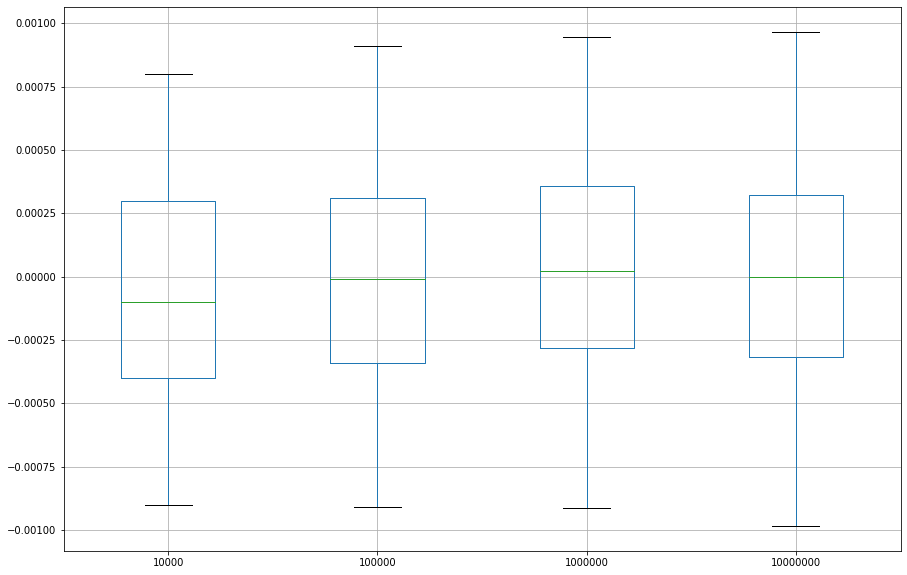

In [ ]:
import pandas as pd

df = pd.DataFrame(error_data)

df.boxplot(label="Random input errors", figsize=(15, 10))

In the boxplot above we can observe that error rate does not exceeds 1e-3 absolute error rate fixed in algorithm constructor, and becomes more stable as N increases. 

### Performance on sorted input of various sizes

In [ ]:
def test_sorted_accuracy(N, nq=100):
    N = int(N)
    gk = GK01(eps=1e-3)
    data = np.random.randn(N)
    data = np.sort(data)

    gk.add_multiple_items(data)

    qs = [i/(nq + 1) for i in range(1, nq + 1)]

    true_rank = []
    recieved_rank = []
    for q in qs:
        gk_v = gk.compute_quantile(q)
        recieved_rank.append(bisect(data, gk_v))
        true_rank.append(ceil(N * q))
    
    true_rank = np.array(true_rank)
    recieved_rank = np.array(recieved_rank)
    
    return (recieved_rank - true_rank) / N

In [ ]:
ns = [1e4, 1e5, 1e6, 1e7]


error_data = dict()
for n in ns:
    errors = np.array([])
    for _ in range(3):
        if errors.size == 0:
            errors = test_accuracy(n, nq=100)
        else:
            errors = np.concatenate((errors, test_sorted_accuracy(n, nq=100)))
    error_data[int(n)] = errors

<AxesSubplot:>

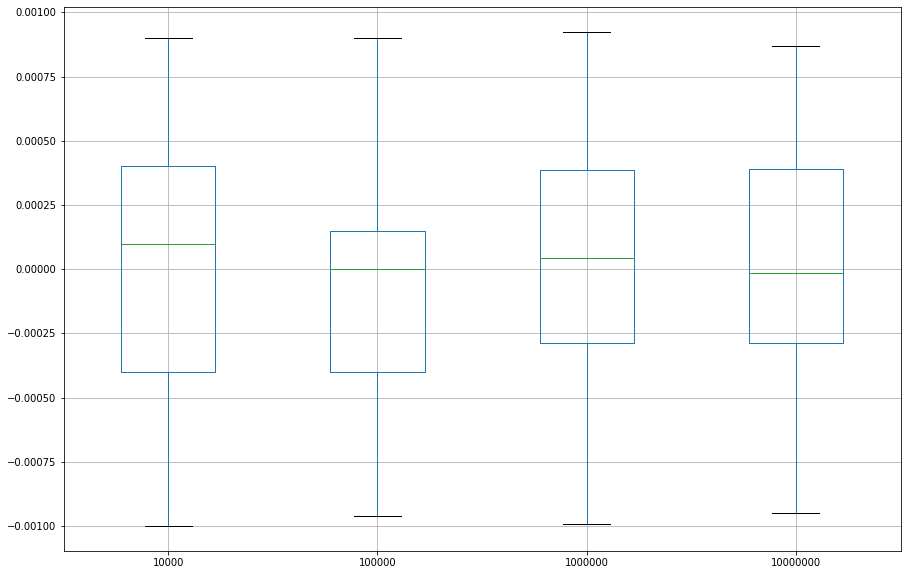

In [ ]:
import pandas as pd

df = pd.DataFrame(error_data)

df.boxplot(figsize=(15, 10))

For the sorted input, we again can observe that error does not exceed 1e-3 absolutely, as expected.

- ✔ Submit to Moodle!